**Table of contents**<a id='toc0_'></a>   
- 1. [Imports](#toc1_)     
- 2. [IS-LM model](#toc2_)    
- 3. [Comparing different estimation solvers](#toc3_)      
- 4. [Model modifications](#toc4_)  
 - 4.1. [IS-LM model with contractionary Monetary and fiscal Policy](#toc4_1_)
 - 4.2. [IS-LM model with fiscal Policy](#toc4_2_)   
- 5. [Interactive figure](#toc5_)    
- 6. [Model extension](#toc6_)

## 1. <a id='toc1_'></a>[Imports](#toc1_)

In [1]:
import seaborn as sns
sns.set(style='whitegrid')

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline
from matplotlib import cm
from matplotlib import rc
import matplotlib.ticker as ticker
import ipywidgets as widgets
from ISLMModel import ODESolver
from ISLMModel import RungeKutta4
from ISLMModel import ForwardEuler
from ISLMModel import *


## 2. <a id='toc2_'></a>[IS-LM model](#toc2_)

The Investment-Savings (IS) Liquidity Preference-Money Supply (LM) model is a Keynesian macroeconomic framework that depicts the interaction between the goods market and the money market to determine the equilibrium between interest rates and total economic output in the economy. It provides a simplified representation of the economy, enabling policymakers to gain insights into stimulating economic activity through the behavior of various economic agents.

In the IS-LM model, we begin with the goods market. As per basic economics, the Gross Domestic Product (GDP) at any given time (t) is the sum of household consumption, investment, government spending, and net exports. For this model, we assume a closed economy, meaning there is no international trade, and the country operates in an independent economy.

\begin{align*}
Y(t) = C(t) + I(t) + G(t) \tag{1}                      
\end{align*}

Household consumption $C(t)$ is given as:

\begin{align*}
C(t) = a + bY_d(t) \tag{2}                      
\end{align*}

Disposable income of households refer to the difference between $Y(t)$ and total taxes $T(t)$.

\begin{align*}
Y_d(t) = Y(t) - T(t) \tag{3}
\end{align*}

The level of taxes $T(t)$ is described by the sum of the fixed taxes $T$ and the variable taxes given as a percentange $\lambda$ multiplied with GDP $Y(t)$.

\begin{align*}
T(t) = T + \lambda Y(t) \tag{4}
\end{align*}

The total amount of investment at any time $t$ refers to the difference between the level of autonomous investments $I_o$ and the product of the sensitivity of the investment in relation to the interest rate $h$ and the real interest rate $r$.

\begin{align*}
I(t) = I_o - h r(t) \tag{5}
\end{align*}

Lastly, we set government expenditure as fixed.

\begin{align*}
G(t) = \bar{G} \tag{6}
\end{align*}


The money market:

The demand for money, denoted as $M_d(t)$, can be expressed as the sum of the autonomous demand for money ($M_o$) and the product of the sensitivity of the demand for money to output ($k$) and the Gross Domestic Product ($Y(t)$). However, the demand for money is inversely related to the interest rate ($r$), with the reduction in demand being proportional to the sensitivity of the demand for money to the interest rate ($\mu$) multiplied by the interest rate itself.

\begin{align*}
M_d(t) = M_o + k Y(t) - \mu r(t) \tag{7}
\end{align*}

The money supply in the economy is fixed.

\begin{align*}
M_s(t) = \bar{M} \tag{8}
\end{align*}

Lastly, we have the market clearing condition that the demand for money must equal to the supply for money.

\begin{align*}
M_d(t) = M_s(t) \tag{9}
\end{align*}


We attempt to model the change in output $Y(t)$ with respect to time $t$ by taking the derivative of $Y$ with respect to $t$:

\begin{align*}
\frac{dy}{dt} = \alpha(C(t) + I(t) + G(t) - Y(t)) \tag{10}
\end{align*}

where $\alpha$ refers to the speed of adjustment to equilibrium in the goods market.

We now derive the differential equations that explains the change of output (GDP) over time, following the IS-LM model.

Plugging in equation 2-6 we get:

\begin{align*}
\frac{dy}{dt} = \alpha(a + bY_d(t) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a + b(Y(t) - T(t)) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a + b(Y(t) - (T_o + \lambda Y(t))) + I_o - hr(t) + \bar{G} - Y(t)) 
\end{align*}

\begin{align*}
\frac{dy}{dt} = \alpha(a - bT_o + I_o + \bar{G}) - \alpha((1-b)(1-\lambda)Y(t)) - \alpha hr(t) \tag{11}
\end{align*}

We do the same thing to formulate a differential equation that explains the change in real interest rates over time:

\begin{align*}
\frac{dr}{dt} = \beta(M_d(t) - M_s(t)) 
\end{align*}

where $\beta$ refers to the speed of adjustment to equilibrium in the money market.

The IS-LM model assumes that $\beta > \alpha$.

Plugging in equation 7-9, we get:

\begin{align*}
\frac{dr}{dt} = \beta(M_o + k Y(t) - \mu r(t) - \bar{M}) 
\end{align*}

\begin{align*}
\frac{dr}{dt} = \beta(M_o - \bar{M} + k Y(t) - \mu r(t)) \tag{12}
\end{align*}


The system of ordinary differential equations that we will be modeling in this notebook is represented by equations 11 and 12. These equations depend on the variables Y(t) and r(t), which are the endogenous variables in this dynamic model.

In contrast, the variables $T$, $I_o$, and $M_o$ are policy variables that are treated as exogenous in the IS-LM model. 

### 3. <a id='toc3_'></a>[Comparing different estimation solvers](#toc3_)

The following section of code of defines and solves the model, using the Forward Euler solver and the ODE solver.

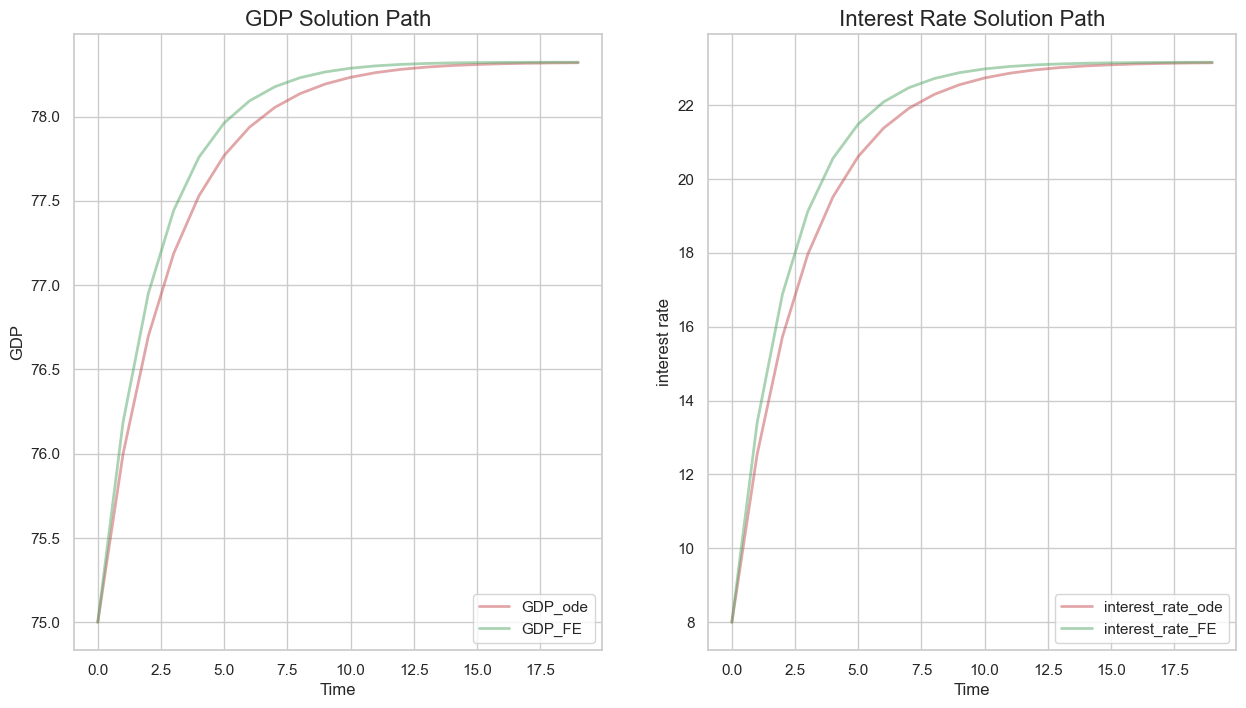

In [2]:
#Parameters for the model

a = 15 # consumption
I_0 = 10 # investment
T_0 = 0 # fixed taxes
M_0 = 0 # Money demand
alpha_val = 0.05 # speed of adjustment in goods market
beta_val = 0.8  # speed of adjustment in money market
lambda_val = 0.25 # variable taxes
b = 0.75 # marginal propensity to consume 
h = 1.525 # sensitivity of investment in relation to interest rates
k = 0.25 # sensitivity of demand for money in relation to GDP
mu_val = 0.5 # sensitivity of demand for money in relation to interest rates
G = 25 # government spending
M = 8 # money supply fixed

time_points = np.arange(0, 20)

def IS_LM_model(u, t):    
    GDP, interest_rate = u[0], u[1]
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return [dYdt, drdt]


# Initial conditions vector
Y_0 = 75
r_0 = 8

# solve using Forward Euler
solver_FE = ForwardEuler(IS_LM_model)
solver_FE.set_initial_condition([Y_0, r_0])
u, t = solver_FE.solve(time_points)
GDP_FE = u[:, 0]
interest_rate_FE = u[:, 1]

# The IS-LM model differential equations
def system(init_values, t, a, I_0, T_0, M_0, G, M, alpha_val, beta_val, 
           lambda_val, b, h, k, mu_val):
    GDP, interest_rate = init_values
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return dYdt, drdt

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid, t.
ret = odeint(system, init_conds, time_points, args=args_tuple)

GDP_odeint, interest_rate_odeint = ret.T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax[0].plot(t, GDP_odeint, 'r', alpha=0.5, lw=2, label='GDP_ode')
ax[0].plot(t, GDP_FE, 'g', alpha=0.5, lw=2, label='GDP_FE')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GDP')
ax[0].set_title('GDP Solution Path', fontsize=16)
ax[0].legend(loc=4)

ax[1].plot(t, interest_rate_odeint, 'r', alpha=0.5, lw=2, label='interest_rate_ode')
ax[1].plot(t, interest_rate_FE, 'g', alpha=0.5, lw=2, label='interest_rate_FE')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('interest rate')
ax[1].set_title('Interest Rate Solution Path', fontsize=16)
ax[1].legend(loc=4)
plt.show()

From the figure above, we see that the prediction of GDP and the interest rates are lower using the ODE solver, than the Forward Eulrer. This difference grows, as time goes on, until the economy hits its steady state level.

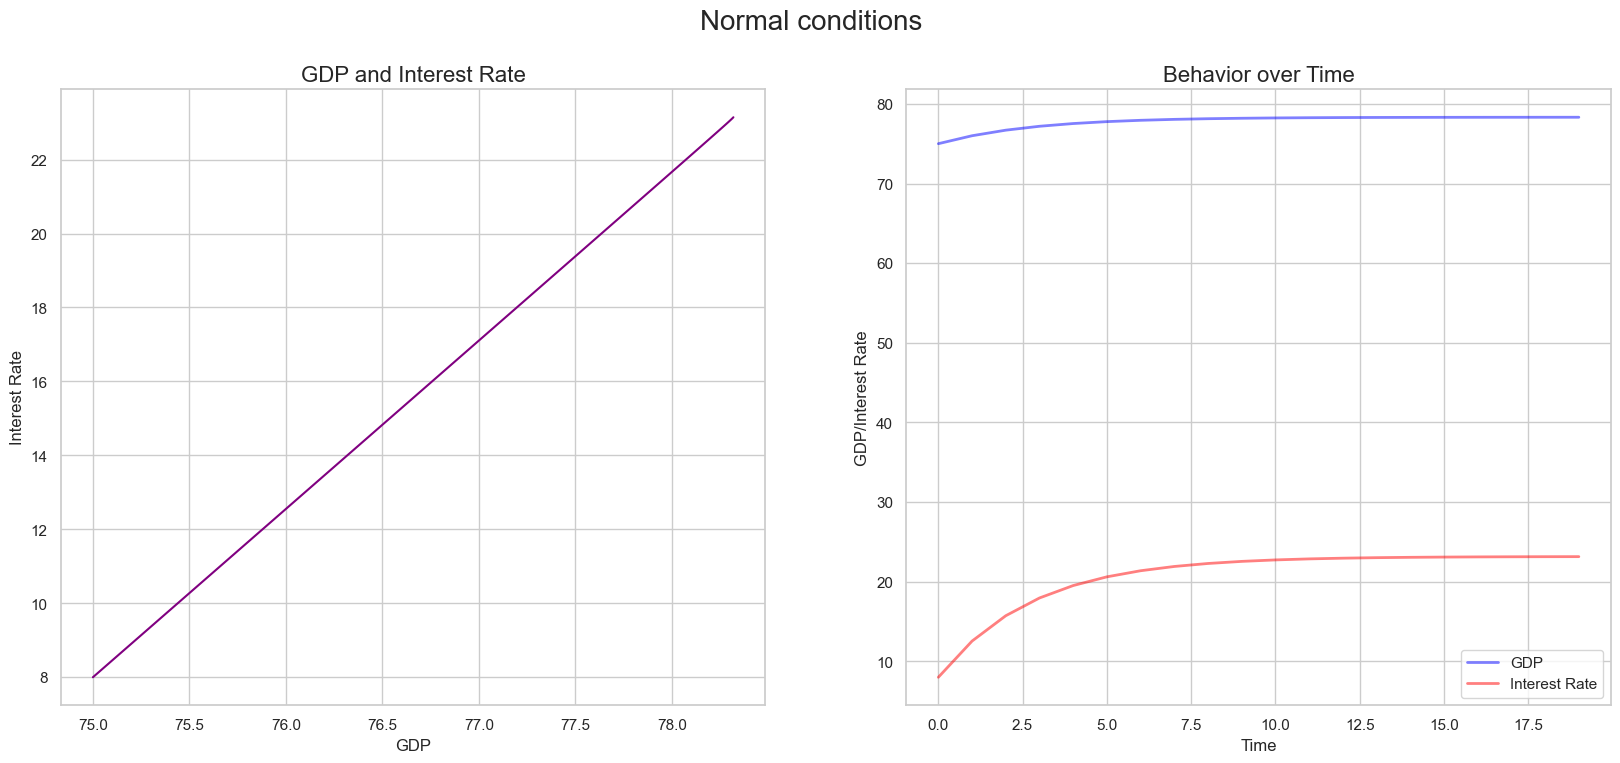

In [3]:
def graph(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)

    ax[0].plot(GDP, interest_rate, color='purple')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')

    ax[1].plot(t, GDP, color='blue', alpha=0.5, lw=2, label='GDP')
    ax[1].plot(t, interest_rate, color='red', alpha=0.5, lw=2, label='Interest Rate')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    plt.show()

graph(GDP_odeint, interest_rate_odeint, t, 'Normal conditions')

In the figure above we have plotted the behavior of GDP and interest rates over time, for the case where the economy is controlled under normal conditions.

### 4. <a id='toc4_'></a>[Model modifications](#toc4_)


In the figures graphing the GDP and interest rate solution paths, the green line shows the model under normal conditions.

### 4.1 <a id='toc4_1_'></a>[IS-LM model with contractionary Monetary and Fiscal Policy ](#toc4_1_)

We are now going to to analyze a scenario where the central bank decreases the money supply, which is done to control inflation levels and volatility in output. In the simulation, the change is implemented by reducing the money supply from 8 to 4. Also, the government increases taxes to support the contractionary monetary policy agenda. 

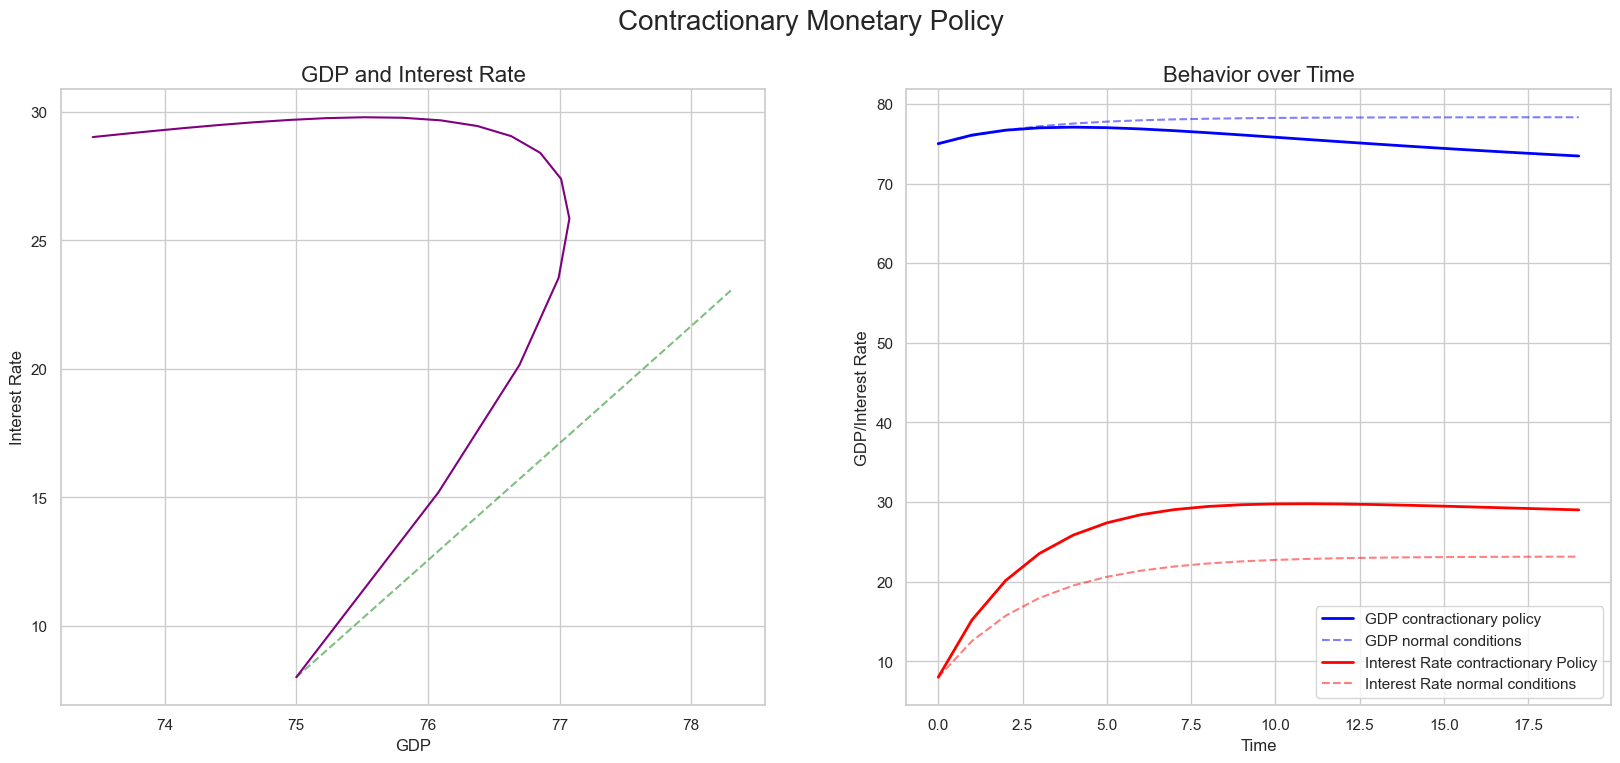

In [4]:
# We only have to change the money supply and the variable taxes to see the effect on the model, since all the paramteres have already been defined, 
M = 4 # Changed money supply from 8 to 4
lambda_val = 0.45 # increase in variable taxes

def contractionarymodification(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)
    
    ax[0].plot(GDP_odeint, interest_rate_odeint, color='Green', alpha=0.5, linestyle='--', label='Normal conditions')
    ax[0].plot(GDP, interest_rate, color='purple', label='Policy')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')

    ax[1].plot(t, GDP, color='blue', lw=2, label='GDP contractionary policy')
    ax[1].plot(t, GDP_odeint, color='blue', alpha=0.5, linestyle='--', label='GDP normal conditions')
    ax[1].plot(t, interest_rate, color='red', lw=2, label='Interest Rate contractionary Policy')
    ax[1].plot(t, interest_rate_odeint, color='red', alpha=0.5, linestyle='--', label='Interest Rate normal conditions')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    plt.show()

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid
ret_contract = odeint(system, init_conds, time_points, args=args_tuple)

GDP_contract, interest_rate_contract = ret_contract.T

contractionarymodification(GDP_contract, interest_rate_contract, time_points, 'Contractionary Monetary Policy')

When the money supply is decreased central banks in order to execute contractionary monetary policy by increasing the interest rate, lending becomes more costly and the domestic investment decreases. Consequently, the economic growth rate decreases which can be seen by the decrease in GDP over time. 


### 4.2. <a id='toc4_2_'></a>[IS-LM model with Fiscal policy changes](#toc4_2_)

Now consider a case where the economy is hit by a recession, which results in a decline in private consumption. Consequently, the marginal propensity to consume for private households will decrease, leading to a decrease in b. The government then reacts by increasing spending to avoid a reduction in GDP, which can be seen as an increase in G. 


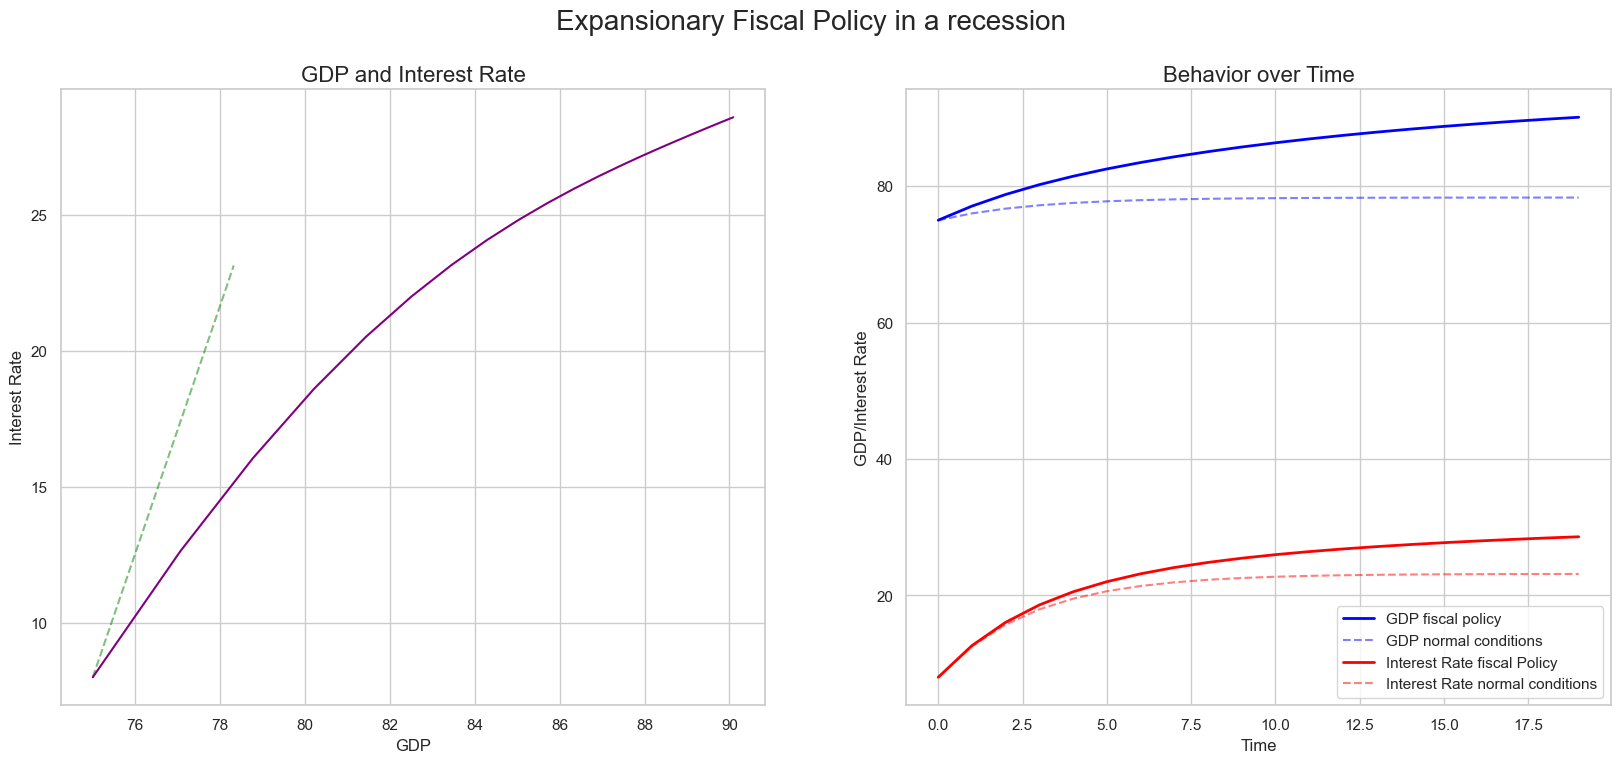

In [5]:
# We only have to change the money supply back to the original value, since all the paramteres have already been defined.
# We change G and B to the new values to see the effect on the model.
G = 75 # Increase in public spending
M = 8 # Money supply changed to original value
lambda_val = 0.25 # original variable taxes
b = 0.25 # reduced from 0.75 to 0.25

def fiscalmodification(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)
    
    ax[0].plot(GDP_odeint, interest_rate_odeint, color='Green', alpha=0.5, linestyle='--', label='Normal conditions')
    ax[0].plot(GDP, interest_rate, color='purple', label='Policy')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')

    ax[1].plot(t, GDP, color='blue', lw=2, label='GDP fiscal policy')
    ax[1].plot(t, GDP_odeint, color='blue', alpha=0.5, linestyle='--', label='GDP normal conditions')
    ax[1].plot(t, interest_rate, color='red', lw=2, label='Interest Rate fiscal Policy')
    ax[1].plot(t, interest_rate_odeint, color='red', alpha=0.5, linestyle='--', label='Interest Rate normal conditions')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    plt.show()

init_conds = Y_0, r_0
args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid, t.
ret_expand = odeint(system, init_conds, time_points, args=args_tuple)

GDP_expand, interest_rate_expand = ret_expand.T

fiscalmodification(GDP_expand, interest_rate_expand, time_points, 'Expansionary Fiscal Policy in a recession')

In the example the government increases its spending. Government spending creates income for workers, creates jobs, and stimulates demand. Government spending dominates the decrease in marginal propensity to consume as the GDP is increased. When the government increases their spending, the central bank will increases the interest rate to offset the economic growth. This could result in inflation spikes. 

### 5. <a id='toc5_'></a>[Interactive figure](#toc5_)


Now we want to create a interactive figure, such that the model can be modified to different values of the parameters to include all kinds of shocks to the economy in different scales.

In [6]:
class SimulationPlotter:
    def __init__(self):
        self.a = 15
        self.I_0 = 10
        self.T_0 = 0
        self.M_0 = 0
        self.G = 25
        self.M = 8
        self.alpha_val = 0.05
        self.beta_val = 0.8
        self.lambda_val = 0.25
        self.b = 0.75
        self.h = 1.525
        self.k = 0.25
        self.mu_val = 0.5
    def IS_LM_model(self, u, t, kwargs):
        GDP, interest_rate = u[0], u[1]
        a = kwargs['a']
        I_0 = kwargs['I_0']
        T_0 = kwargs['T_0']
        M_0 = kwargs['M_0']
        G = kwargs['G']
        alpha_val = kwargs['alpha_val']
        beta_val = kwargs['beta_val']
        lambda_val = kwargs['lambda_val']
        b = kwargs['b']
        h = kwargs['h']
        k = kwargs['k']
        mu_val = kwargs['mu_val']
        dYdt = (
            alpha_val * (a - b * T_0 + I_0 + G)
            - alpha_val * ((1 - b) * (1 - lambda_val) * GDP)
            - alpha_val * h * interest_rate
        )
        drdt = beta_val * (M_0 - self.M + k * GDP - mu_val * interest_rate)
        return [dYdt, drdt]
    def plot_simulations(self, a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val):
        time_points = np.arange(0, 20)
        Y_0 = 75
        r_0 = 8
        # Solve using input parameters
        ret_base = odeint(
            self.IS_LM_model,
            [Y_0, r_0],
            time_points,
            args=({'a': a, 'I_0': I_0, 'T_0': T_0, 'M_0': M_0, 'G': G,
                   'alpha_val': alpha_val, 'beta_val': beta_val, 'lambda_val': lambda_val,
                   'b': b, 'h': h, 'k': k, 'mu_val': mu_val},),
        )
        GDP_base, interest_rate_base = ret_base.T
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
        plt.suptitle("Simulation Plot", fontsize=20)
 
        ax[0].plot(GDP_base, interest_rate_base, color='purple', alpha=0.5, linestyle='--', label='Base')
        ax[0].set_title('GDP and Interest Rate', fontsize=16)
        ax[0].set_xlabel('GDP')
        ax[0].set_ylabel('Interest Rate')
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[1].plot(time_points, GDP_base, color='blue', lw=2, label='GDP')
        ax[1].plot(time_points, interest_rate_base, color='red', lw=2, label='Interest Rate')
        ax[1].set_title('Behavior over Time', fontsize=16)
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('GDP/Interest Rate')
        ax[1].legend()
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        plt.show()
sim_plotter = SimulationPlotter()

# Create sliders
a_slider = widgets.FloatSlider(description="a", min=0, max=20, step=1.0, value=sim_plotter.a)
I0_slider = widgets.FloatSlider(description="I_0", min=1, max=20, step=1.0, value=sim_plotter.I_0)
T0_slider = widgets.FloatSlider(description="T_0", min=0, max=0.20, step=0.01, value=sim_plotter.T_0)
M0_slider = widgets.FloatSlider(description="M_0", min=0, max=20, step=1.0, value=sim_plotter.M_0)
G_slider = widgets.FloatSlider(description="G", min=0, max=100, step=1.0, value=sim_plotter.G)
alpha_slider = widgets.FloatSlider(description="Alpha", min=0.0, max=1.0, step=0.05, value=sim_plotter.alpha_val)
beta_slider = widgets.FloatSlider(description="Beta", min=0, max=1.0, step=0.05, value=sim_plotter.beta_val)
lambda_slider = widgets.FloatSlider(description="Lambda", min=0, max=0.75, step=0.05, value=sim_plotter.lambda_val)
b_slider = widgets.FloatSlider(description="b", min=0, max=1.0, step=0.05, value=sim_plotter.b)
h_slider = widgets.FloatSlider(description="h", min=0, max=5, step=0.05, value=sim_plotter.h)
k_slider = widgets.FloatSlider(description="k", min=0, max=1, step=0.05, value=sim_plotter.k)
mu_slider = widgets.FloatSlider(description="mu", min=0, max=1, step=0.05, value=sim_plotter.mu_val)

# Define the interact function

def interact_plot(a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val):
    sim_plotter.plot_simulations(a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val)
# Create the interactive plot

interactive_plot = widgets.interact(
    interact_plot,
    a=a_slider,
    I_0=I0_slider,
    T_0=T0_slider,
    M_0=M0_slider,
    G=G_slider,
    alpha_val=alpha_slider,
    beta_val=beta_slider,
    lambda_val=lambda_slider,
    b=b_slider,
    h=h_slider,
    k=k_slider,
    mu_val=mu_slider

)
# Display the interactive plot

display(interactive_plot)

interactive(children=(FloatSlider(value=15.0, description='a', max=20.0, step=1.0), FloatSlider(value=10.0, de…

<function __main__.interact_plot(a, I_0, T_0, M_0, G, alpha_val, beta_val, lambda_val, b, h, k, mu_val)>

### 6. <a id='toc6_'></a>[Model extension](#toc6_)

Our extension of the model is, that instead of looking at a closed economy, we will now look at an open economy where exports and imports are possible.
In the extension we only look at the ODE solver.

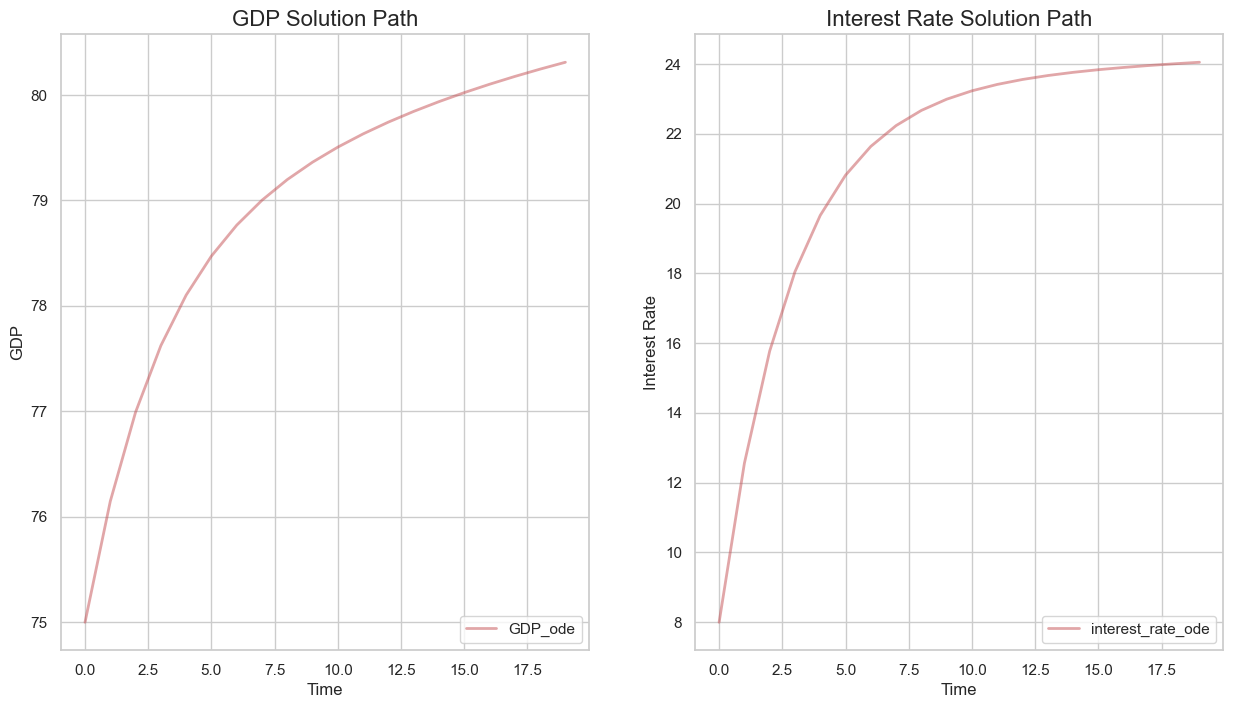

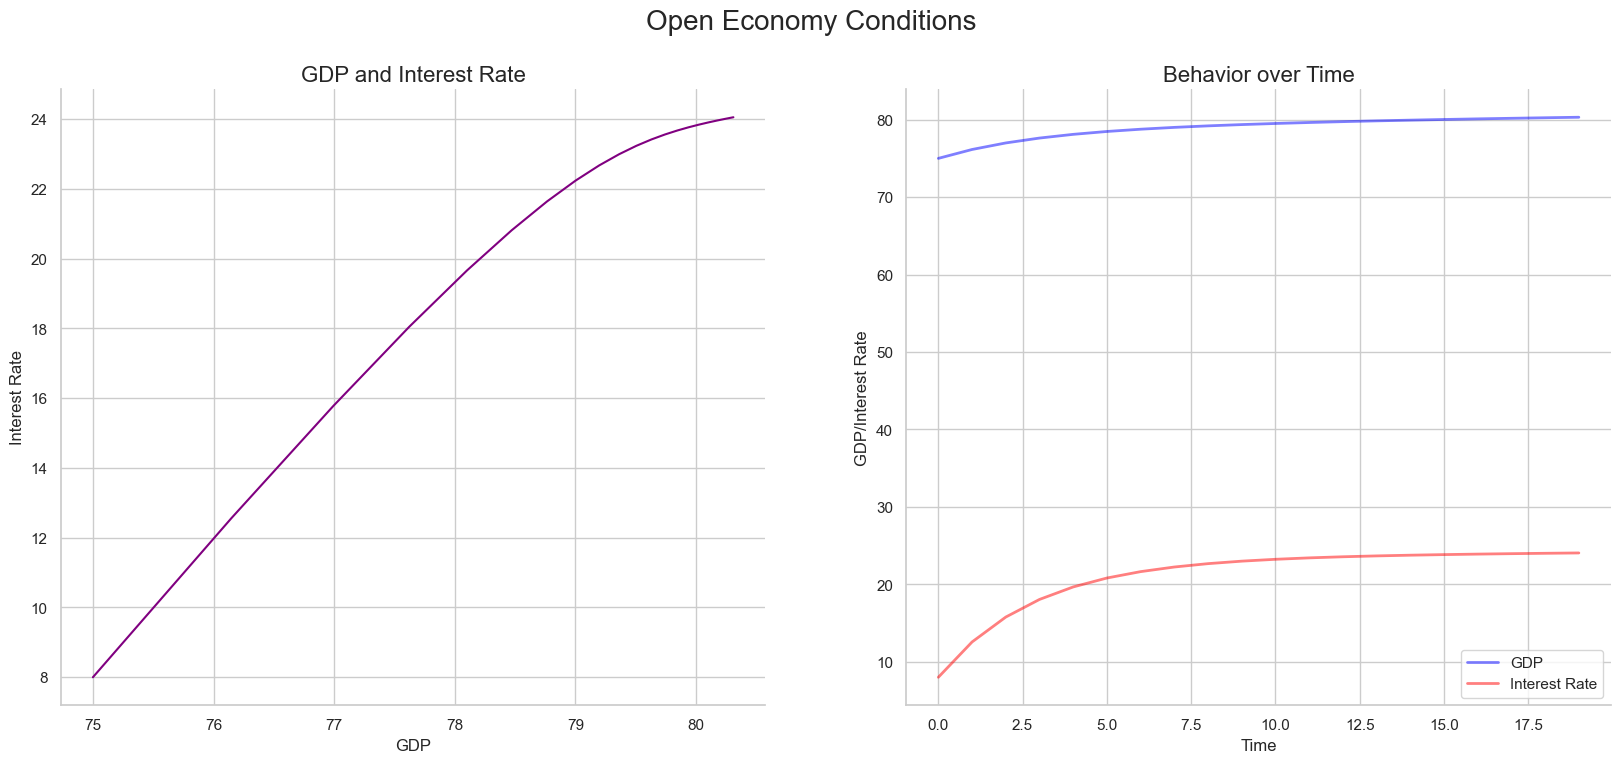

In [7]:
# Parameters for the model extension
a = 15  
I_0 = 10  
T_0 = 0  
M_0 = 0 
alpha_val = 0.05  
beta_val = 0.8  
lambda_val = 0.25  
b = 0.75  
h = 1.525 
k = 0.25 
mu_val = 0.5  
G = 25  
M = 8 
X = 5  # exports
IM = 2  # imports

time_points = np.arange(0, 20)

def IS_LM_model(u, t):    
    GDP, interest_rate = u[0], u[1]
    dYdt = ((alpha_val * (a - b * T_0 + I_0 + G + X - IM)) - 
            (alpha_val * ((1-b) * (1-lambda_val) * GDP)) - 
            (alpha_val * h * interest_rate)) 
    drdt = beta_val * (M_0 - M + k * GDP - (mu_val * interest_rate))
    return [dYdt, drdt]

# Initial conditions vector
Y_0 = 75
r_0 = 8

# Integrate the IS-LM differential equations over the time grid, t.
ret = odeint(IS_LM_model, [Y_0, r_0], time_points)

GDP_odeint, interest_rate_odeint = ret[:, 0], ret[:, 1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax = ax.flatten()
ax[0].plot(time_points, GDP_odeint, 'r', alpha=0.5, lw=2, label='GDP_ode')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('GDP')
ax[0].set_title('GDP Solution Path', fontsize=16)
ax[0].legend(loc=4)

ax[1].plot(time_points, interest_rate_odeint, 'r', alpha=0.5, lw=2, label='interest_rate_ode')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Interest Rate')
ax[1].set_title('Interest Rate Solution Path', fontsize=16)
ax[1].legend(loc=4)
plt.show()

def plot_graphs(GDP, interest_rate, t, case):
    """Visualize GDP and interest rate along with their behavior over time."""
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)
    ax = ax.flatten()

    ax[0].plot(GDP, interest_rate, color='purple')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)

    ax[1].plot(t, GDP, color='blue', alpha=0.5, lw=2, label='GDP')
    ax[1].plot(t, interest_rate, color='red', alpha=0.5, lw=2, label='Interest Rate')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    plt.show()

plot_graphs(GDP_odeint, interest_rate_odeint, time_points, 'Open Economy Conditions')


Now we want to look at the contractionary policy in the open economy.

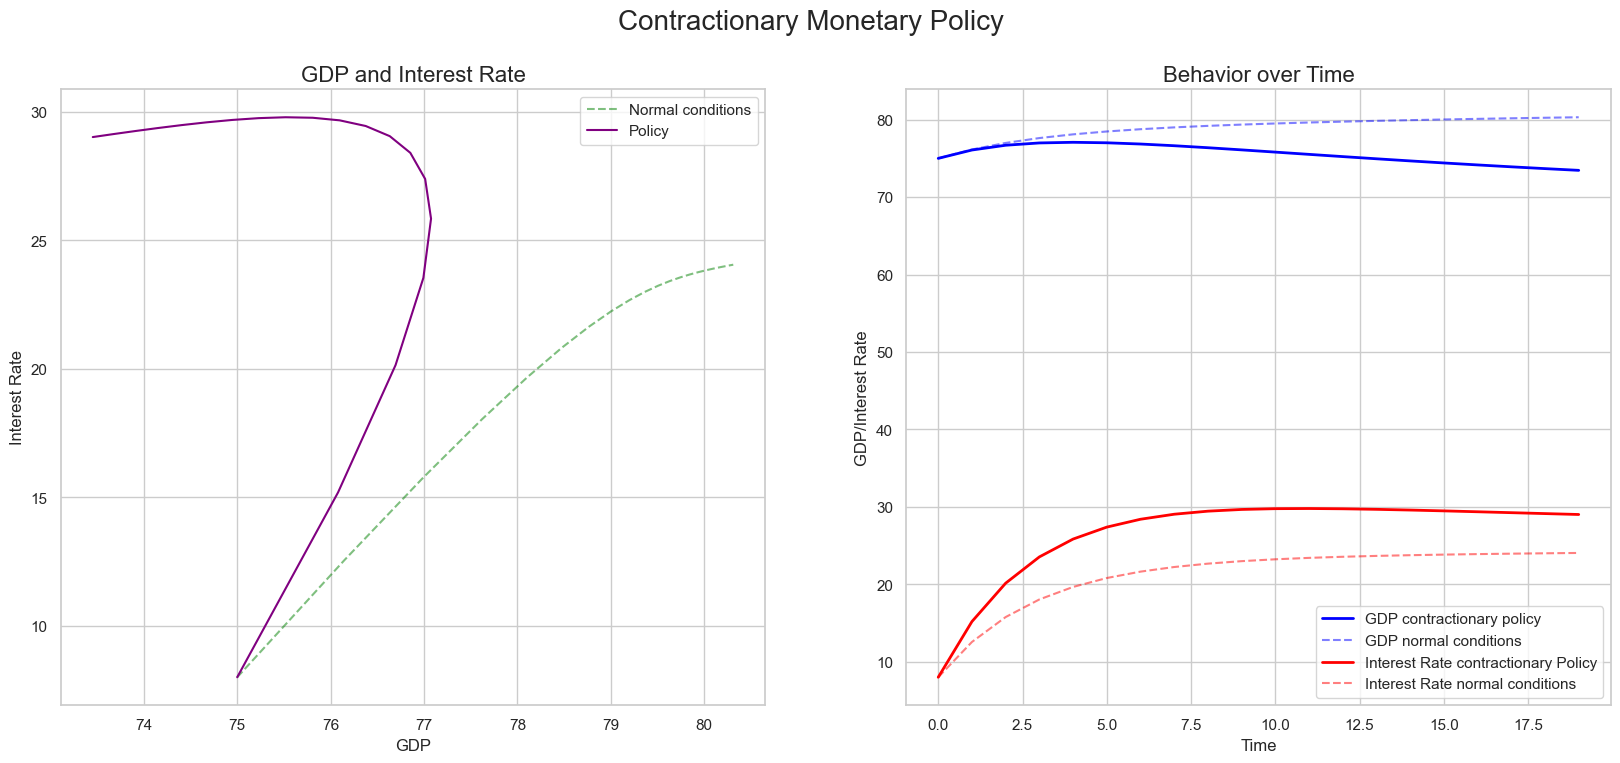

In [8]:
# Since all the parameters have already been defined, we only have to change the money supply and the variable taxes to see the effect on the model.
M = 4  # Changed money supply
lambda_val = 0.45  # increase in variable taxes

def contractionary_modification(GDP, interest_rate, t, case):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    plt.suptitle(case, fontsize=20)

    ax[0].plot(GDP_odeint, interest_rate_odeint, color='green', alpha=0.5, linestyle='--', label='Normal conditions')
    ax[0].plot(GDP, interest_rate, color='purple', label='Policy')
    ax[0].set_title('GDP and Interest Rate', fontsize=16)
    ax[0].set_xlabel('GDP')
    ax[0].set_ylabel('Interest Rate')
    ax[0].legend()

    ax[1].plot(t, GDP, color='blue', lw=2, label='GDP contractionary policy')
    ax[1].plot(t, GDP_odeint, color='blue', alpha=0.5, linestyle='--', label='GDP normal conditions')
    ax[1].plot(t, interest_rate, color='red', lw=2, label='Interest Rate contractionary Policy')
    ax[1].plot(t, interest_rate_odeint, color='red', alpha=0.5, linestyle='--', label='Interest Rate normal conditions')
    ax[1].set_title('Behavior over Time', fontsize=16)
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('GDP/Interest Rate')
    ax[1].legend()

    plt.show()

args_tuple = (a, I_0, T_0, M_0, G, M, alpha_val, beta_val, lambda_val, b, h, k, mu_val)

# Integrate the IS-LM differential equations over the time grid
ret_contract = odeint(system, init_conds, time_points, args=args_tuple)

GDP_contract, interest_rate_contract = ret_contract.T

contractionary_modification(GDP_contract, interest_rate_contract, time_points, 'Contractionary Monetary Policy')

As it can be seen from the figures above, in an open economy, the GDP of a country becomes more affected compared to a closed economy. The reason is that an open economy is exposed to external economies and international trade. This economy engages in international trade, both in imports and exports which affects the GDP. 